In [1]:
import os
from pathlib import Path

#auto load the eemeter module
import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt

from hourly_test_utils import *
from applied_data_science.bigquery.data import Meter_Data
from eemeter import eemeter as em
from eemeter.common.metrics import BaselineMetrics as Metrics

In [2]:
dataset = 'mce_3_yr_precovid'
subsample = 5
has_solar = True

cache_dir = Path("/app/.recurve_cache/data").resolve()

if 'data' in globals():
    del data

data = Meter_Data(dataset, subsample, "hourly", solar=has_solar, cache_dir=cache_dir)
meta = data.df['meta']
subsample_df = data.df['meter']
ids = subsample_df.index.unique()

Loading: /app/.recurve_cache/data/MCE/MCE_3_yr_precovid_solar_meta_5.pkl
Done in 0.002 s
Loading: /app/.recurve_cache/data/MCE/MCE_3_yr_precovid_solar_hourly_meter_5.pkl
Done in 0.981 s


In [3]:
sid = ids[20]
lat = meta.loc[meta.index == sid].iloc[0]['station_latitude']
lon = meta.loc[meta.index == sid].iloc[0]['station_longitude']
sd = subsample_df.loc[sid].copy()
metadata = {'lat': lat, 'lon': lon, 'sid': sid}
config = {
    'window': 1
}
data_loader = MCE_Data_Loader_Test(config)
sid, df_trains, df_tests = data_loader.get_all_cleaned_data(metadata, sd)

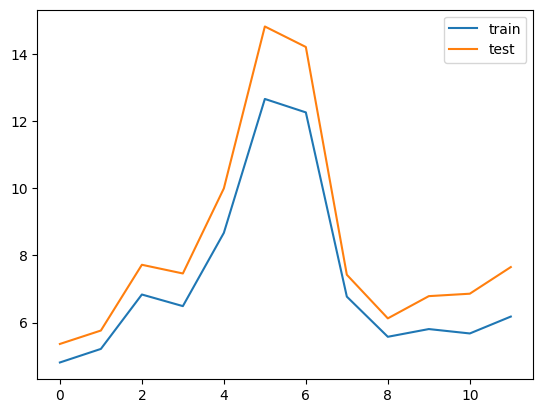

In [4]:
settings = em.HourlySettings(
    TRAIN_FEATURES=[],
    LAGGED_FEATURES=['temperature'], # 'ghi'
    WINDOW=1,
    OUTPUT_FEATURES=['start_local', 'temperature', 'ghi', 'clearsky_ghi', 'observed', 'predicted', 'month'],
    SUPPLEMENTAL_DATA=False,
    ALPHA=0.1,
    L1_RATIO=0.1,
    SELECTION="cyclic",
    MAX_ITER=1000,
    SEED=42
)

err_type = 'cvrmse'

model = em.HourlyModel(settings=settings)
tr_errors = []
te_errors = []
for k in range(len(df_trains)):
    model.fit(df_trains[k])
    tr_errors.append(getattr(model.baseline_metrics, err_type))

    # new_df = model.predict(df_trains[k])
    new_df = model.predict(df_tests[k])
    num_model_parameters = model.baseline_metrics.num_model_params
    tr_metrics = Metrics(df=new_df, num_model_params=num_model_parameters)

    if err_type == "cvrmse":
        err = tr_metrics.rmse / model.baseline_metrics.observed.mean
    elif err_type == "pnrmse":
        err = tr_metrics.rmse / model.baseline_metrics.observed.iqr

    te_errors.append(err)

plt.plot(tr_errors, label='train')
plt.plot(te_errors, label='test')
plt.legend()

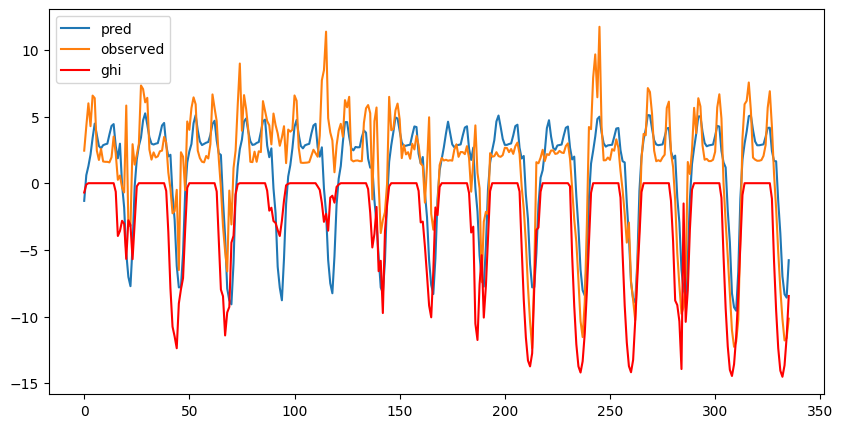

In [5]:
start = 24*70
window = 24*14
end = start + window
plt.rcParams['figure.figsize'] = [10, 5]

plt.plot(new_df['predicted'][start:end].values, label='pred')
plt.plot(new_df['observed'][start:end].values, label='observed')
plt.plot(-new_df['ghi'][start:end].values*20, label='ghi', c='r')
plt.legend()
plt.show()

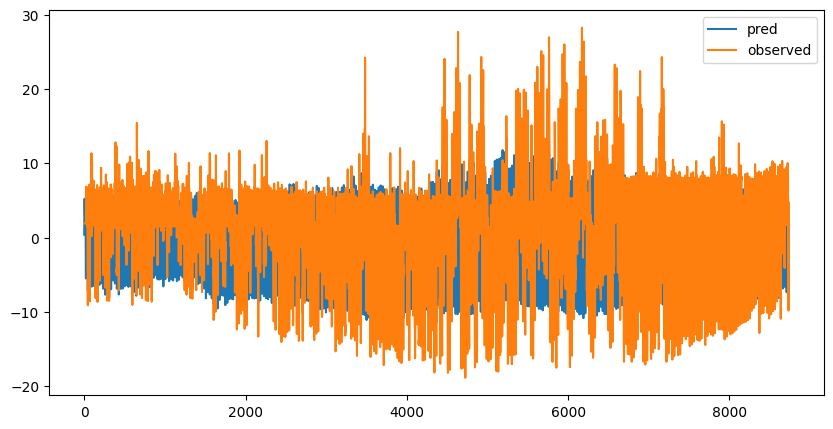

In [6]:
start = 24*0
window = 365*24-24
end = start + window
plt.rcParams['figure.figsize'] = [10, 5]

plt.plot(new_df['predicted'][start:end].values, label='pred')
plt.plot(new_df['observed'][start:end].values, label='observed')
# plt.plot(-new_df['ghi'][start:end].values*20, label='ghi', c='r')
plt.legend()
plt.show()

In [7]:
# Testing Serialization

json = model.to_json()
new_model = em.HourlyModel.from_json(json)
# new_model.baseline_metrics.observed.iqr - model.baseline_metrics.observed.iqr
new_model.baseline_metrics.pnrmse - model.baseline_metrics.pnrmse

0.0